### Identify if there are characteristics that might signify revolutions (major leaps) in musical evolution from these data? What artists represent revolutionaries (influencers of major change) in your network?

In [55]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import math

In [345]:
artists = pd.read_csv('data_by_artist.csv')
artists = artists.drop_duplicates(subset='artist_name', keep='last')
artists[80:90]

,artist_name,artist_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity,count
80,Neil Young,379125,0.511677,0.397089,0.494641,126.167687,-12.942327,1,7,0.460809,0.046176,0.256286,0.037686,254191.5612,38.605442,294
81,Julie London,247966,0.425233,0.188913,0.275022,106.086712,-14.608791,1,10,0.815055,0.006661,0.164768,0.047037,156406.7842,21.181507,292
82,Los Tigres del Norte,806336,0.753952,0.518852,0.893810,123.423041,-9.289872,1,9,0.379285,0.000155,0.163390,0.118937,186968.8241,43.720690,290
83,Stan Getz,742899,0.501307,0.237282,0.523630,113.312850,-16.695554,1,5,0.877871,0.313541,0.163593,0.047590,305771.3937,21.557491,287
84,Green Day,154544,0.403968,0.898068,0.656616,138.006135,-4.260135,1,1,0.018499,0.020255,0.196684,0.071501,204988.3381,47.925267,281
85,Marty Robbins,858710,0.578662,0.339302,0.547685,114.574801,-11.804406,1,4,0.799804,0.008368,0.183821,0.040553,180774.1922,25.245552,281
86,Bill Evans,61912,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
87,Bill Evans,74005,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
88,Bill Evans,764702,0.484232,0.226042,0.356796,103.714032,-17.886479,1,0,0.879193,0.634696,0.135222,0.043088,310919.1286,25.903571,280
89,Bee Gees,43714,0.558565,0.510842,0.597418,107.119078,-11.204190,1,7,0.247674,0.046172,0.245669,0.039678,228251.3048,42.553903,269


In [129]:
years = pd.read_csv('data_by_year.csv')
years

,year,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,duration_ms,popularity
0,1921,0.425661,0.236784,0.425495,100.397758,-17.095437,1,7,0.895823,0.322330,0.215814,0.077258,229911.9141,0.351562
1,1922,0.480000,0.237026,0.534056,101.376139,-19.179958,1,10,0.939236,0.440470,0.238647,0.115419,167904.5417,0.138889
2,1923,0.568462,0.246936,0.624788,112.456598,-14.373882,1,0,0.976329,0.401932,0.236656,0.098619,178356.3018,5.727811
3,1924,0.548654,0.347033,0.668574,120.653359,-14.202304,1,10,0.935575,0.583955,0.237875,0.090210,188461.6498,0.603376
4,1925,0.571890,0.264373,0.616430,115.671715,-14.516707,1,5,0.965422,0.408893,0.243094,0.115457,184130.6996,2.707224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2016,0.599976,0.592877,0.430769,119.070344,-7.949913,1,0,0.280290,0.074646,0.180198,0.107298,219400.7638,61.371254
96,2017,0.612286,0.586739,0.414465,116.840277,-8.422697,1,1,0.289916,0.098209,0.194218,0.111752,209343.6130,64.861500
97,2018,0.664930,0.590591,0.447141,122.004325,-7.253666,1,1,0.271941,0.035948,0.171781,0.128140,200919.1190,67.276000
98,2019,0.644215,0.578796,0.465856,118.868163,-8.041738,1,1,0.289298,0.076518,0.167161,0.124799,197733.1330,69.655500


In [41]:
from tqdm import tqdm
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)

full


  0%|                                                                                        | 0/98340 [00:00<?, ?it/s]C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102913,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster,Pop/Rock
102914,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love,Pop/Rock
102915,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese,Pop/Rock
102916,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster,Pop/Rock


In [132]:
influence = pd.read_csv('influence_data.csv')
influence

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990
...,...,...,...,...,...,...,...,...
42765,580300,Sufjan Stevens,Pop/Rock,1990,3661738,Rosemary & Garlic,Pop/Rock,2010
42766,261309,Vybz Kartel,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010
42767,467203,Michael Jackson,R&B;,1960,3670556,Trinidad Cardona,R&B;,2010
42768,2518003,Popcaan,Reggae,2000,3670556,Trinidad Cardona,R&B;,2010


In [44]:
idDict = {}
for i in range(len(artists)):
    try:
        idDict[artists['artist_id'][i]] = artists['artist_name'][i]
    except:
        pass

iGraph = nx.DiGraph()
for artist in artists['artist_id']:
    iGraph.add_node(artist, weight = 0)
    
for i in range(len(influence)):
    influencer = influence["influencer_id"][i]
    follower = influence['follower_id'][i]
    
    iGraph.add_edge(influencer,follower)    

arts = []
artnames = []
scores = []
for node in iGraph.nodes():
    children = list(iGraph.successors(node))
    total = 0
    for child in children:
        total += iGraph.out_degree[child]
        
    iGraph.nodes[node]['weight'] = total
    arts.append(node)
    try:
        artnames.append(idDict[node])
    except KeyError:
        artnames.append('Unknown')
    scores.append(total)
    
   
totalInfluence = pd.DataFrame({'names':artnames, 'artists':arts, 'scores':scores})
totalInfluence = totalInfluence.sort_values(by=['scores'], ascending = False)
totalInfluence = totalInfluence.reset_index(drop=True)
totalInfluence

,names,artists,scores
0,The Beatles,754032,11223
1,Bob Dylan,66915,7923
2,The Rolling Stones,894465,6337
3,Chuck Berry,120521,5893
4,Elvis Presley,180228,4743
...,...,...,...
5847,Joss Stone,286572,0
5848,She Wants Revenge,328201,0
5849,Jonathan Coulton,329542,0
5850,No Use for a Name,344037,0


In [136]:
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)
genre

['Pop/Rock',
 'Electronic',
 'Reggae',
 'Jazz',
 'Country',
 'Comedy/Spoken',
 'R&B;',
 'Classical',
 'Latin',
 'Vocal',
 'Folk',
 'Easy Listening',
 'International',
 'Avant-Garde',
 'Blues',
 'Stage & Screen',
 'New Age',
 'Religious',
 "Children's",
 'Unknown']

In [137]:
artistByGenre = {}
for i in genre:
    artistByGenre[i] = []
i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1

In [155]:
genreFeatures = []
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    means = means.to_numpy()
    genreFeatures.append(means)

In [202]:
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    print(i)
    print(means['tempo'])

Pop/Rock
0.5041980713608971
Electronic
0.49042630707112583
Reggae
0.4774755289800211
Jazz
0.462278082020503
Country
0.4900360207138811
Comedy/Spoken
0.43481045095581794
R&B;
0.47720687330073297
Classical
0.4364707118746228
Latin
0.4904744919256894
Vocal
0.4515249429416114
Folk
0.4755359158889776
Easy Listening
0.4548916454260138
International
0.4750882932243574
Avant-Garde
0.45780935105224024
Blues
0.4824690364704632
Stage & Screen
0.4256400818155745
New Age
0.4554467713904153
Religious
0.4926720395705324
Children's
0.4874728923340553
Unknown
0.49486651100803203


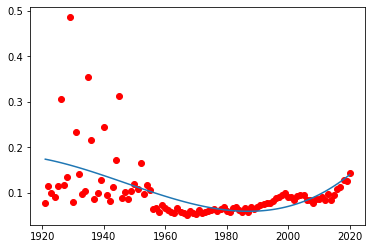

In [42]:
year = years['year']
attribute = years['speechiness']
plt.plot(year, attribute, 'ro')
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 3))(np.unique(year)))

In [76]:
minSpeech = years.sort_values(by=['speechiness'])
minSpeech = minSpeech.reset_index(drop=True)
minYears = []
for i in range(5):
    minYears.append(minSpeech['year'][i])
minSpeechSongs = full[full['year'].isin(minYears)]
minSpeechSongs = minSpeechSongs.sort_values(by=['popularity'], ascending=False)
minSpeechSongs = minSpeechSongs.reset_index(drop=True)
influentialArtists = []
for i in range(math.floor(0.05*len(minSpeechSongs))):
    df = totalInfluence[totalInfluence['names'] == minSpeechSongs['artist_names'][i]]
    if len(df) > 0:
        index = df.index[0]
        if index < 0.01 * len(totalInfluence):
            influentialArtists.append(minSpeechSongs['artist_names'][i])   
influentialArtists = set(influentialArtists)
influentialArtists = list(influentialArtists)
influentialArtists

['Bob Dylan',
 'Roy Orbison',
 'The Shadows',
 'Cream',
 'The Rolling Stones',
 'The Kinks',
 'Black Sabbath',
 'Jackie Wilson',
 'The Isley Brothers',
 'Marvin Gaye',
 'David Bowie',
 'Johnny Cash',
 'Jimi Hendrix',
 'Elvis Presley',
 'Neil Young',
 'The Who',
 'The Beatles',
 'The Byrds',
 'Otis Redding',
 'The Beach Boys',
 'Sam Cooke',
 'The Velvet Underground',
 'Led Zeppelin',
 'John Coltrane']

In [70]:
indexes = list(np.where(totalInfluence['names'] == 'Vicente Fernández'))
indexes


[array([], dtype=int64)]

In [74]:
totalInfluence[totalInfluence['names'] == 'The Beatles'].index[0]

0